# 영화 관객 예측
***


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as snsß
%matplotlib inline

In [2]:
train = pd.read_csv("../data/영화 관객수/movies_train.csv")
test = pd.read_csv('../data/영화 관객수/movies_test.csv')
submission = pd.read_csv('../data/영화 관객수/submission.csv')

In [3]:
train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


In [4]:
test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


In [5]:
submission.head(3)

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0


#### 배급사 전처리

In [6]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [7]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [8]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [9]:
train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

#### 장르별 영화 관객수 평균값으로 랭크 인코딩

In [10]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [11]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

#### 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

In [12]:
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_nm_rank

,distributor,num_rank
109,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
51,사람과사람들,42.0
96,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
111,전망좋은영화사,1214237.0
104,이십세기폭스코리아,1422844.0
55,쇼박스,2138560.0
83,영구아트무비,2541603.0


In [13]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

In [14]:
tr_nm_rank

,distributor,num_rank
109,인피니티엔터테인먼트,1
15,고구마공작소,2
51,사람과사람들,3
96,위드시네마,4
19,나우콘텐츠,5
...,...,...
111,전망좋은영화사,143
104,이십세기폭스코리아,144
55,쇼박스,145
83,영구아트무비,146


#### 최종 데이터 병합

In [15]:
train = pd.merge(train, tr_nm_rank, how = 'left')
test = pd.merge(test, tr_nm_rank, how = 'left')
test.fillna(0, inplace = True)

In [16]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,genre_rank,num_rank
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,11,134
1,내부자들,쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,12,145
2,은밀하게 위대하게,쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,11,145
3,나는 공무원이다,NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,9,140
4,불량남녀,쇼박스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,9,145


## EDA
### 1. 변수간 상관관계 확인

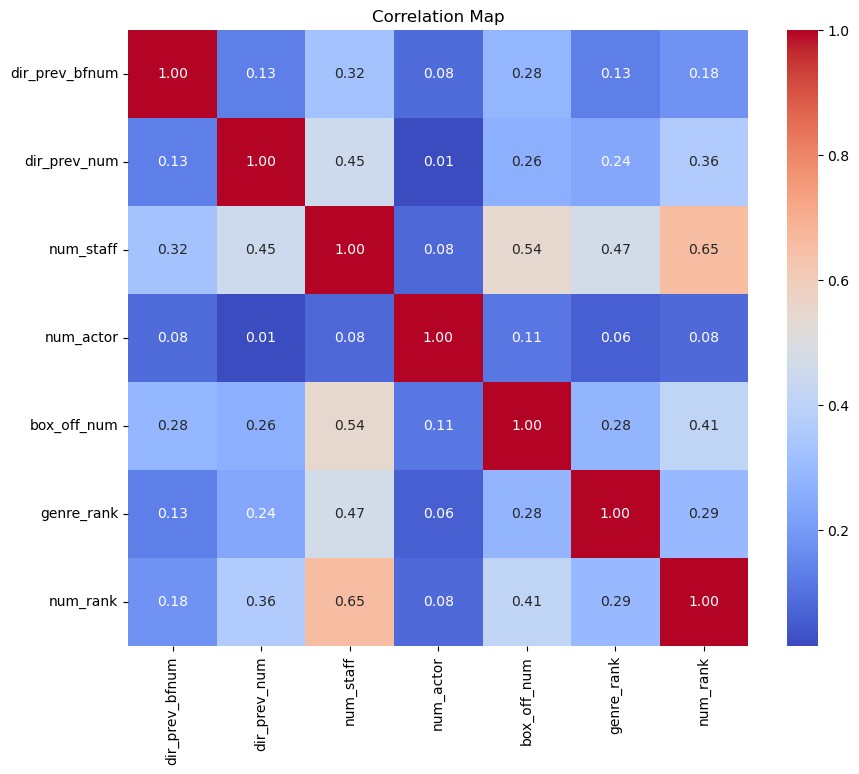

In [17]:
corr = train[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'genre_rank', 'num_rank']].corr()
corr

# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Map')
plt.show()

- 강한상관관계 : num_staff & num_rank (|0.6|과 |0.8| 사이)
- 중간상관관계 : box_off_num & num_staff / num_staff & dir_prev_num / box_off_num & num_rank / num_staff & genre_rank (|0.4|과 |0.6| 사이)
- 약한상관관계 : num_staff & genre_rank / dir_prev_num & num_rank / num_staff & dir_prev_bfnum ((|0.2|과 |0.4| 사이))

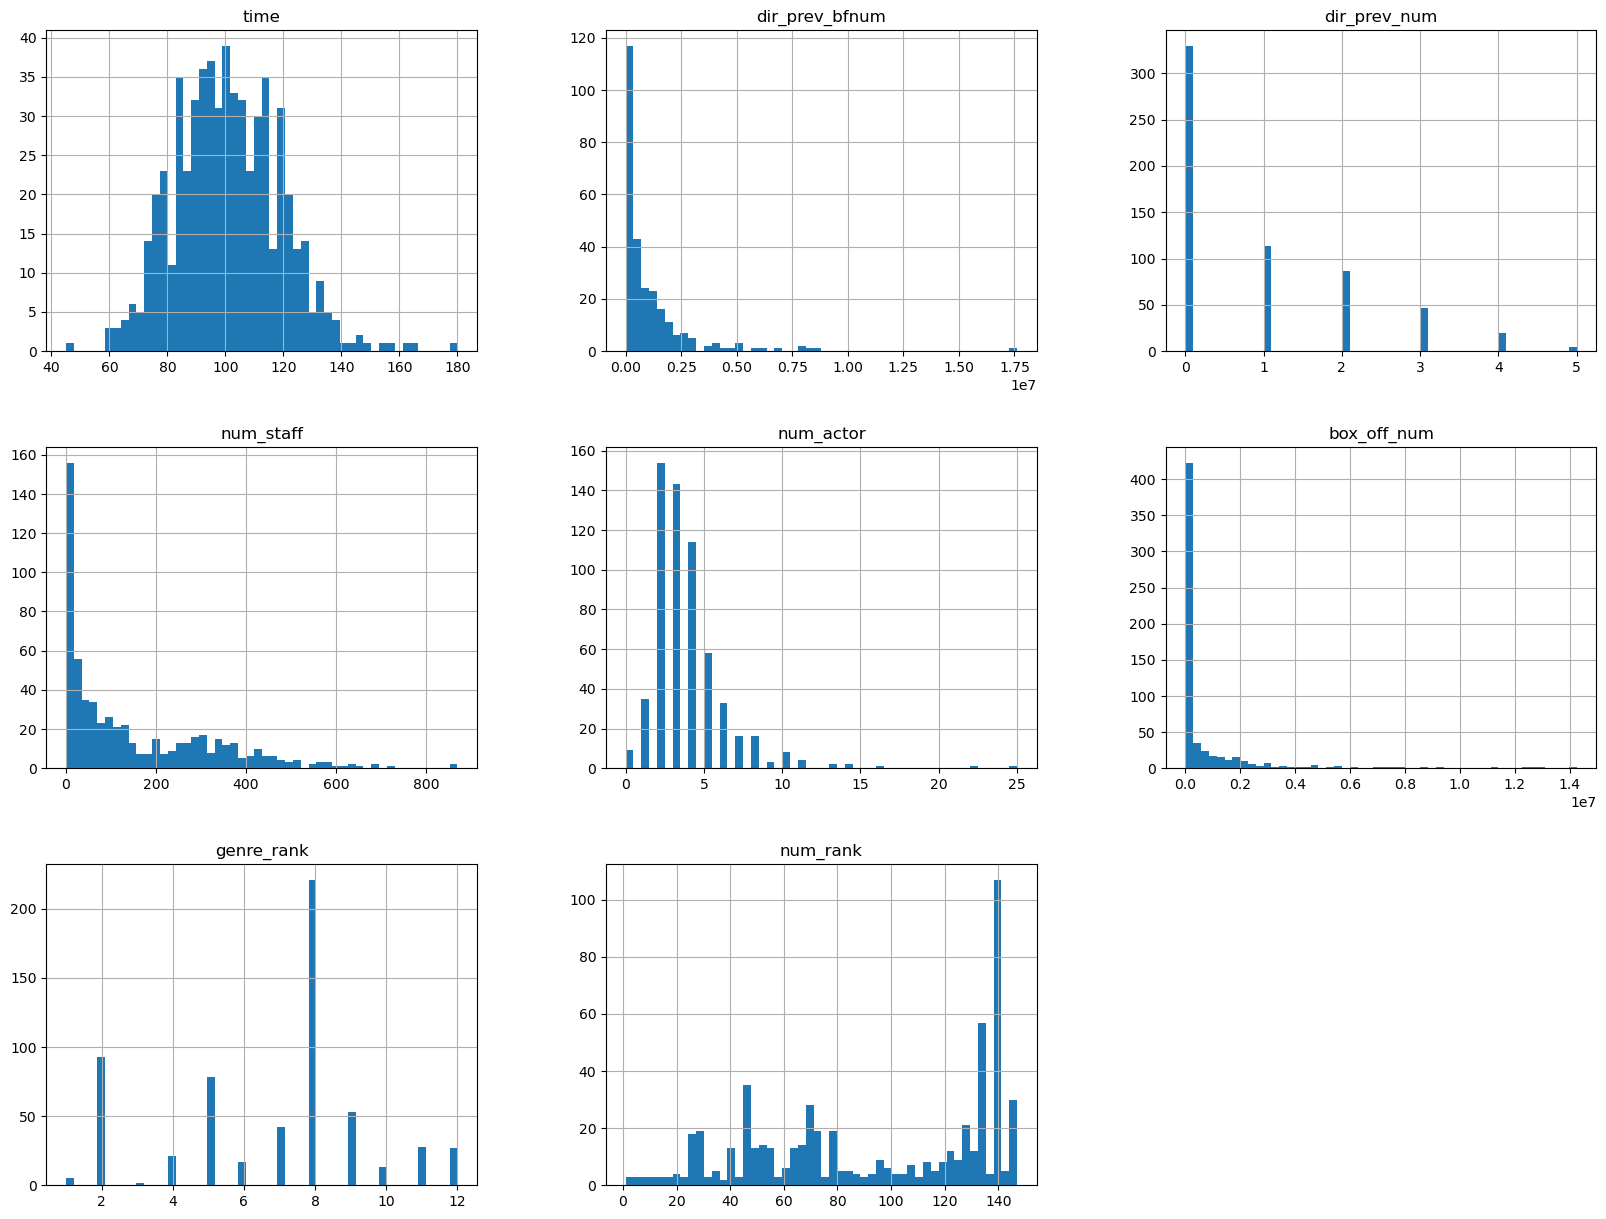

In [18]:
# 히스토그램
train.hist(bins=50, figsize=(20,15))
plt.show()

- 왼쪽으로 치우치거나, 오른쪽으로 치우친 왜곡된 분포는 log 변환 필요

**log1p** : StandardScaler가 아니라 로그 변환 -> 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나. 
- 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 줌
    - 선형회귀모델과 같은 선형 모델은 일반적으로 피처와 타깃값 간에 선형 관계가 있다고 가정하고, 이러한 최적의 선형함수를 찾아내 결괏값을 예측   
    - 선형 회귀 모델은 피처값과 타깃값의 분포가 정규 분포(평균을 중심으로 종 모양으로 데이터 값이 분포된 형태)를 매우 선호   
    - 특히 타깃값의 경우 정규 분포 형태가 아니라 특정값에 분포가 치우친 왜곡된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높음   
    - 피처값 역시 결정값보다는 덜하지만 왜곡된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 수 있음. 따라서 선형 회귀 모델을 적용하기 전에 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적   
    - 이것을 선행한다고 무조건 예측 성능이 향상되는 것은 아님.  
    - 일반적으로 중요 피처들이나 타깃값의 분포도가 심하게 왜곡됐을 경우이런 변환 작업 수행  

#### 모델링 데이터 구성
- 타겟 값인 관객수를 로그변환
- 상영등급은 더미 변수
- 출연 배우 수(왼쪽으로 치우친 분포)는 로그변환

In [19]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from ngboost import NGBRegressor

In [20]:
X = train[['num_rank', 'time', 'num_staff', 'num_actor', 'genre_rank', 'screening_rat']]
X['num_actor'] = np.log1p(X['num_actor']) # 배우수(치우친 분포) 처리
y = np.log1p(train.box_off_num) # 관객 수 처리

In [21]:
X = pd.get_dummies(columns = ['screening_rat'], data = X)

In [22]:
X

,num_rank,time,num_staff,num_actor,genre_rank,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,134,96,91,1.098612,11,False,False,False,True
1,145,130,387,1.386294,12,False,False,False,True
2,145,123,343,1.609438,11,False,True,False,False
3,140,101,20,1.945910,9,False,False,True,False
4,145,108,251,1.098612,9,False,True,False,False
...,...,...,...,...,...,...,...,...,...
595,140,111,510,2.079442,8,False,False,False,True
596,145,127,286,1.945910,8,False,True,False,False
597,46,99,123,1.609438,7,False,False,False,True
598,141,102,431,1.609438,12,False,True,False,False


In [23]:
target = test[['num_rank', 'time', 'num_staff', 'num_actor', 'genre_rank', 'screening_rat']]
target = pd.get_dummies(columns = ['screening_rat'], data = target)
target['num_actor'] = np.log1p(target['num_actor'])

#### K-Fold로 교차검증 (k=10)

In [24]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

### 5가지 모델 사용
#### 1) GradientBoostingRegressor

In [25]:
gbm = GradientBoostingRegressor(random_state = 42)

In [26]:
rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)]) # 예측값 원래 분포로 돌려놓기
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred)) # RMSE값 추가
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10) # 각 폴드 에서 얻은 예측값 gb_pred에 추가

In [27]:
np.mean(rmse_list)

1174378.9765191546

#### 2) NGBRegressor

In [28]:
ngb = NGBRegressor(random_state = 518)

In [29]:
rmse_list = []
ngb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    ngb_pred += (sub_pred / 10)

[iter 0] loss=2.6200 val_loss=0.0000 scale=1.0000 norm=2.9523
[iter 100] loss=1.9566 val_loss=0.0000 scale=2.0000 norm=2.7106
[iter 200] loss=1.5812 val_loss=0.0000 scale=2.0000 norm=2.1869
[iter 300] loss=1.4423 val_loss=0.0000 scale=2.0000 norm=2.0889
[iter 400] loss=1.3728 val_loss=0.0000 scale=1.0000 norm=1.0177
[iter 0] loss=2.6082 val_loss=0.0000 scale=1.0000 norm=2.9152
[iter 100] loss=1.9528 val_loss=0.0000 scale=2.0000 norm=2.7146
[iter 200] loss=1.5771 val_loss=0.0000 scale=1.0000 norm=1.0949
[iter 300] loss=1.4462 val_loss=0.0000 scale=1.0000 norm=1.0483
[iter 400] loss=1.3703 val_loss=0.0000 scale=1.0000 norm=1.0197
[iter 0] loss=2.6264 val_loss=0.0000 scale=1.0000 norm=2.9872
[iter 100] loss=1.9504 val_loss=0.0000 scale=2.0000 norm=2.6683
[iter 200] loss=1.5552 val_loss=0.0000 scale=2.0000 norm=2.1459
[iter 300] loss=1.4287 val_loss=0.0000 scale=1.0000 norm=1.0292
[iter 400] loss=1.3405 val_loss=0.0000 scale=1.0000 norm=0.9976
[iter 0] loss=2.6185 val_loss=0.0000 scale=1.0

In [30]:
np.mean(rmse_list)

982090.1458698185

### 2번 모델 활용 예측 시행

In [52]:
X_new = X.drop(columns={'num_staff'})
X_new.head()

,num_rank,time,num_actor,genre_rank,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,134,96,1.098612,11,False,False,False,True
1,145,130,1.386294,12,False,False,False,True
2,145,123,1.609438,11,False,True,False,False
3,140,101,1.945910,9,False,False,True,False
4,145,108,1.098612,9,False,True,False,False


In [31]:
top200 = pd.read_csv('/Users/hwkim/Documents/ds_study/ML_prj/TOP200_movies_info.csv').drop(columns='Unnamed: 0')
top200.head()

,영화명,개봉일,관객수,배급사,관람등급,상영시간,장르,주연배우수
0,명량,2014-07-30,17616299,(주)씨제이이엔엠,15세이상관람가,128분,"사극, 액션",3
1,극한직업,2019-01-23,16266480,(주)씨제이이엔엠,15세이상관람가,111분,코미디,5
2,신과함께-죄와 벌,2017-12-20,14414658,롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,139분,"판타지, 드라마",4
3,국제시장,2014-12-17,14265682,(주)씨제이이엔엠,12세이상관람가,126분,드라마,4
4,어벤져스: 엔드게임,2019-04-24,13977602,월트디즈니컴퍼니코리아 유한책임회사,12세이상관람가,180분,"액션, SF",12


In [32]:
top200.rename(columns={'영화명':'title', '개봉일':'release_time', '관객수':'box_off_num', '배급사':'distributor', '상영시간':'time', '관람등급':'screening_rat', '장르':'genre', '주연배우수':'num_actor'}, inplace=True)
top200.head()

,title,release_time,box_off_num,distributor,screening_rat,time,genre,num_actor
0,명량,2014-07-30,17616299,(주)씨제이이엔엠,15세이상관람가,128분,"사극, 액션",3
1,극한직업,2019-01-23,16266480,(주)씨제이이엔엠,15세이상관람가,111분,코미디,5
2,신과함께-죄와 벌,2017-12-20,14414658,롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,139분,"판타지, 드라마",4
3,국제시장,2014-12-17,14265682,(주)씨제이이엔엠,12세이상관람가,126분,드라마,4
4,어벤져스: 엔드게임,2019-04-24,13977602,월트디즈니컴퍼니코리아 유한책임회사,12세이상관람가,180분,"액션, SF",12


In [33]:
# 장르 한가지로 columns 수정 (둘 중 우선순위가 높은 장르를 선택하게 하거나, 가장 첫번째 뜨는 장르만 남겨두거나)

### 첫 번째 장르만 남겨두는 경우 ###
def get_first_genre(genres):
    return genres.split(', ')[0]

top200['genre'] = top200['genre'].apply(get_first_genre)

### 분 삭제 후 int로 형변환 ###
top200['time'] = top200['time'].str.replace('분', '').astype(int)
top200.head()

,title,release_time,box_off_num,distributor,screening_rat,time,genre,num_actor
0,명량,2014-07-30,17616299,(주)씨제이이엔엠,15세이상관람가,128,사극,3
1,극한직업,2019-01-23,16266480,(주)씨제이이엔엠,15세이상관람가,111,코미디,5
2,신과함께-죄와 벌,2017-12-20,14414658,롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,139,판타지,4
3,국제시장,2014-12-17,14265682,(주)씨제이이엔엠,12세이상관람가,126,드라마,4
4,어벤져스: 엔드게임,2019-04-24,13977602,월트디즈니컴퍼니코리아 유한책임회사,12세이상관람가,180,액션,12


In [34]:
def get_dis(x) :
    if 'CJ' in x or '씨제이' in x:
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    elif '롯데' in x:
        return '롯데엔터테인먼트'
    else :
        return x

In [35]:
top200['distributor'] = top200.distributor.str.replace("(주)", '')
top200['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in top200.distributor]
top200['distributor'] = top200.distributor.apply(get_dis)

In [36]:
top200['genre_rank'] = top200.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

In [54]:
top200['genre_rank'].fillna(0, inplace=True) # nan값 -> 0으로 대체
top200 = pd.merge(top200, tr_nm_rank, how = 'left')
top200.fillna(0, inplace = True)

# 관람연령 전처리
def age_limit(age):
    if age == '15세관람가' or age == '15세이상관람가':
        return '15세 관람가'
    elif age == '12세관람가' or age == '12세이상관람가':
        return '12세 관람가'
    elif age == '18세관람가' or age == '청소년관람불가':
        return '청소년 관람불가'
    elif age == '전체관람가':
        return '전체 관람가'
    
top200_target = top200[['num_rank', 'time', 'num_actor', 'genre_rank', 'screening_rat']]
top200_target['num_actor'] = np.log1p(top200_target['num_actor']) # 배우수(치우친 분포) 처리
top200_target['screening_rat'] = top200_target.screening_rat.apply(age_limit)
top200_target = pd.get_dummies(columns = ['screening_rat'], data = top200_target)
top200_target['genre_rank'] = top200_target['genre_rank'].astype(int)
    
top200_target.head()

,num_rank,time,num_actor,genre_rank,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,141.0,128,1.386294,0,False,True,False,False
1,141.0,111,1.791759,9,False,True,False,False
2,134.0,139,1.609438,0,True,False,False,False
3,141.0,126,1.609438,8,True,False,False,False
4,0.0,180,2.564949,11,True,False,False,False


In [59]:
ngb_pred_total = np.zeros((test.shape[0]))

for tr_idx, val_idx in kf.split(X_new, y):
    tr_x, tr_y = X_new.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X_new.iloc[val_idx], y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(top200_target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    # 예측값 새로운 변수에 누적
    ngb_pred_total[:len(sub_pred)] += sub_pred

# 최종 예측값은 각 반복에서의 예측값 평균
ngb_pred = ngb_pred_total / 10


[iter 0] loss=2.6200 val_loss=0.0000 scale=1.0000 norm=2.9523
[iter 100] loss=1.9942 val_loss=0.0000 scale=2.0000 norm=2.8409
[iter 200] loss=1.6800 val_loss=0.0000 scale=1.0000 norm=1.1783
[iter 300] loss=1.5705 val_loss=0.0000 scale=2.0000 norm=2.2777
[iter 400] loss=1.5005 val_loss=0.0000 scale=2.0000 norm=2.2286
[iter 0] loss=2.6082 val_loss=0.0000 scale=1.0000 norm=2.9152
[iter 100] loss=1.9513 val_loss=0.0000 scale=2.0000 norm=2.7500
[iter 200] loss=1.6439 val_loss=0.0000 scale=2.0000 norm=2.3280
[iter 300] loss=1.5352 val_loss=0.0000 scale=1.0000 norm=1.1294
[iter 400] loss=1.4797 val_loss=0.0000 scale=1.0000 norm=1.1083
[iter 0] loss=2.6264 val_loss=0.0000 scale=1.0000 norm=2.9872
[iter 100] loss=1.9891 val_loss=0.0000 scale=2.0000 norm=2.7947
[iter 200] loss=1.6686 val_loss=0.0000 scale=2.0000 norm=2.3105
[iter 300] loss=1.5385 val_loss=0.0000 scale=1.0000 norm=1.1116
[iter 400] loss=1.4654 val_loss=0.0000 scale=1.0000 norm=1.0902
[iter 0] loss=2.6185 val_loss=0.0000 scale=1.0

In [60]:
np.mean(rmse_list)

865775.0679355803

In [75]:
# 예측값 데이터프레임
predictions_df = pd.DataFrame({'Prediction': ngb_pred.astype(int)})[:200]

predictions_df['Real_box_off_num'] = top200['box_off_num']
predictions_df['diff'] = abs(predictions_df['Real_box_off_num'] - predictions_df['Prediction'])
predictions_df['title'] = top200['title']
predictions_df.sort_values(by='diff') # 명량이 예측 실패 -> 장르의 부재??

,Prediction,Real_box_off_num,diff,title
180,3915913,3897969,17944,박수건달
155,4358035,4313871,44164,엑스맨: 데이즈 오브 퓨처 패스트
121,5313158,4945484,367674,킹스맨: 골든 서클
157,3917876,4300365,382489,아이언맨
151,3928102,4425235,497133,아이언맨 2
...,...,...,...,...
5,12,13768797,13768785,겨울왕국 2
4,7,13977602,13977595,어벤져스: 엔드게임
2,285371,14414658,14129287,신과함께-죄와 벌
1,1151802,16266480,15114678,극한직업


#### 3) LGBMRegressor

In [41]:
lgbm = LGBMRegressor(random_state = 518)

In [42]:
rmse_list = []
lgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    lgb_pred += (sub_pred / 10)

python(18333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 540, number of used features: 9
[LightGBM] [Info] Start training from score 9.903639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [43]:
np.mean(rmse_list)

1213815.0440528719

#### 4) XGBRegressor

In [44]:
xgb = XGBRegressor(random_state = 518)

In [45]:
rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)

In [46]:
np.mean(rmse_list)

1382034.27901073

#### 5) CatBoostRegressor

In [47]:
cat = CatBoostRegressor(random_state = 518, silent = True)

In [48]:
rmse_list = []
cat_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cat.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in cat.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in cat.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    cat_pred += (sub_pred / 10)

In [49]:
np.mean(rmse_list)

1075600.9209088846

#### 6) RandomForestRegressor

In [50]:
rf = RandomForestRegressor(random_state = 518)

In [51]:
rmse_list = []
rf_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    rf_pred += (sub_pred / 10)

In [52]:
np.mean(rmse_list)

872738.262092494

***

#### 최종 예측 결과 블렌딩

In [53]:
submission['box_off_num'] = (xgb_pred + cat_pred + lgb_pred + rf_pred + gb_pred + ngb_pred) / 6

In [54]:
submission.sort_values(by = 'box_off_num')

,title,box_off_num
130,댄서김의 은밀한 교수법,1.282086e+01
39,REC 알이씨,1.538308e+01
139,화려한 외출,2.069543e+01
173,옹녀뎐,2.209055e+01
65,엄마는 창녀다,2.816205e+01
...,...,...
229,베테랑,4.181149e+06
135,용의자,4.234345e+06
142,박수건달,5.137313e+06
179,군도: 민란의 시대,6.340270e+06


In [507]:
submission.to_csv("0520.csv", index = False)